# Preliminary

In [210]:
import requests
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LinearRegression

# Stock Data from TD Ameritrade

Note that the API only permits 120 calls per minute.

## Function Definitions

In [211]:
def TD_stock_quote(ticker):
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/quotes".format(ticker)
    payload = {'apikey': "Insert API Key here"}
    content = requests.get(url = endpoint, params = payload)
    data = content.json()
    
    return data[list(data.keys())[0]]['mark']

In [212]:
def TD_stock_data(tickers, payload):
    #Get historical stock data from TD Ameritrade. 
    #Payload is defined beforehand and determines the type of data we extract.
    #Output is a Pandas.DataFrame object
    
    prices = []
    volumes = []
    
    for ticker in tickers:
        endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(ticker)
        content = requests.get(url = endpoint, params = payload)
        data = content.json()
        
        dates = [str(time.strftime('%y-%m-%d', time.localtime(data["candles"][i]["datetime"]/1000))) for i in range(len(data["candles"]))]
        prices.append([data["candles"][i]["close"] for i in range(len(data["candles"]))])
        volumes.append([data["candles"][i]["volume"] for i in range(len(data["candles"]))])
        
    prices = np.transpose(np.array(prices))
    volumes = np.transpose(np.array(volumes))
    #table = pd.DataFrame(prices, index = dates, columns = tickers)
    return prices, volumes, dates

# Relationship Between APE and AMC Prices

APE is a "preferred equity" offering of AMC. AMC was initially split into AMC and APE as a way for AMC to fund cash to resolve their debt issues. Following a shareholder vote at a later time, APE and AMC shareholders can vote to convert APE back to common stock. See https://www.tastylive.com/news-insights/amc-ape-preferred-stock-all-you-need-to-know for more info

In [213]:
payload = {'apikey': "Insert API Key Here",
            'periodType': 'day',
            'frequencyType':'minute',
            'frequency':'10',
            'period':'10',
            'needExtendedHoursData':'false'}

tickers = ['AMC', 'APE']

In [214]:
prices,volumes, dates = TD_stock_data(tickers, payload)
returns = (prices[1:] - prices[0:-1])/prices[0:-1]
volumes = volumes[1:]

0.5325931205982405 0.0014957161782564255


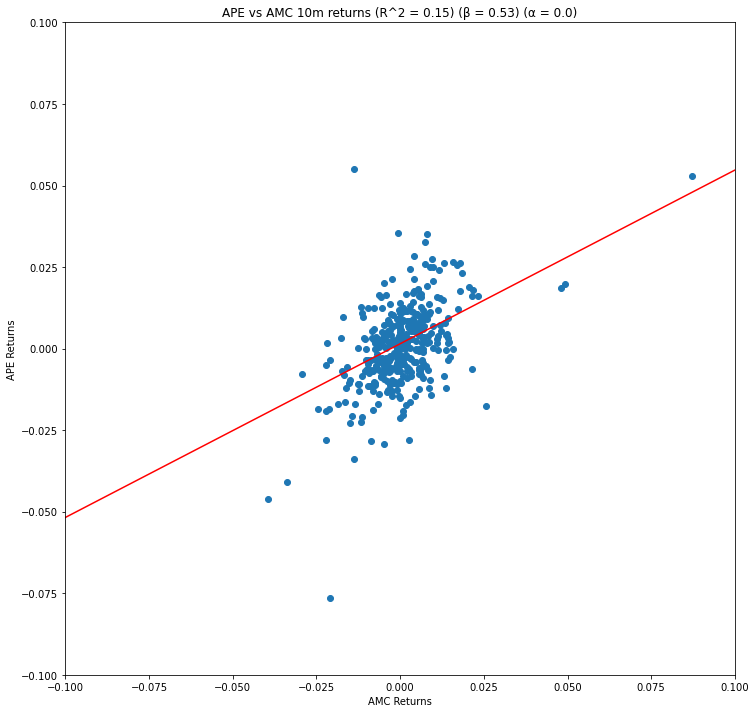

In [215]:
fig, ax = plt.subplots()
AMC_returns = returns[:,0]
APE_returns = returns[:,1]

ax.scatter(AMC_returns, APE_returns)

x_low = -0.1
x_high = 0.1

y_low = -0.1
y_high = 0.1

reg = LinearRegression().fit(AMC_returns.reshape(-1,1), APE_returns.reshape(-1,1))
R2 = reg.score(AMC_returns.reshape(-1,1), APE_returns.reshape(-1,1))
M = reg.coef_[0][0]
B = reg.intercept_[0]
print(M,B)

N = 10000
x_line = np.array([x_low + (i/(N-1))*(x_high - x_low) for i in range(N)])
y_line = M*x_line + B
ax.plot(x_line,y_line, color = "red")

ax.set_title("APE vs AMC 10m returns (R^2 = " + str(np.round(R2,2)) + ")" 
             + " (β = " + str(np.round(M,2)) +")" + " (α = " + str(np.round(B,2)) +")")
ax.set(xlim = (x_low,x_high), ylim = (y_low,y_high))
ax.set_xlabel("AMC Returns")
ax.set_ylabel("APE Returns")
fig.set_size_inches(12,12)

## Computation of Price Impact

Here, I use price data to measure the price impact of trades. To keep things simple, I'm going to assume naively that the price dynamics are something of the form $dP_t = P_t\lambda_t\,dY_t$ (like in Back 1992) and divide returns by volumes to compute what $\lambda_t$ is.

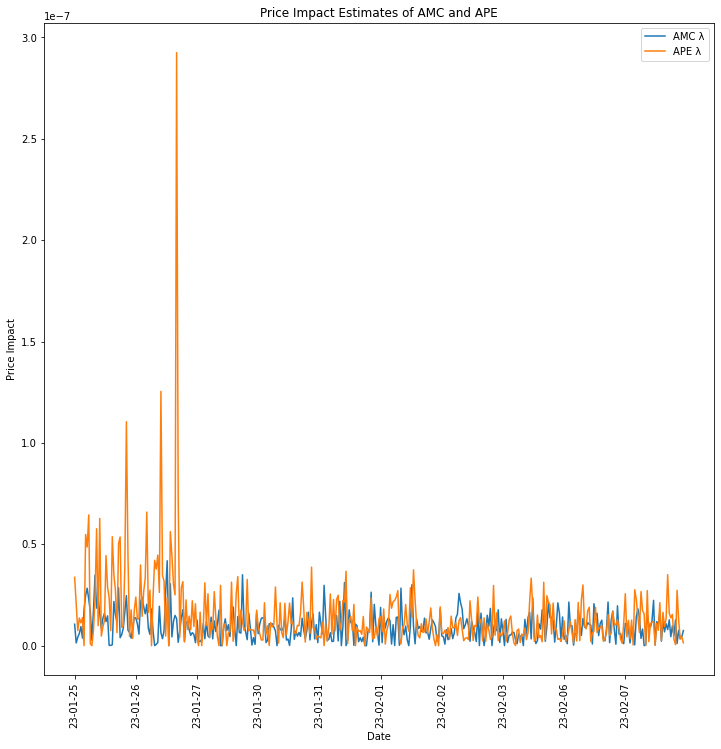

In [216]:
fig, ax = plt.subplots()
price_impact = np.abs(returns)/volumes
ax.plot(price_impact)
ax.legend(['AMC λ', 'APE λ'])
ax.set_xticks([i for i in np.arange(0,np.shape(returns)[0],39)])
ax.set_xticklabels([dates[39*i+1] for i in range(np.shape(ax.get_xticks())[0])])
ax.tick_params(axis='x', rotation=90)
ax.set_title("Price Impact Estimates of AMC and APE")
ax.set_ylabel("Price Impact")
ax.set_xlabel("Date")

fig.set_size_inches(12,12)
#original_labels = [str(label) for label in ax.get_xticks()]
#labels_of_interest = ['test' for i in np.arange(0,np.shape(returns)[0],10)]
#new_labels = [labels_of_interest[10*i] if np.mod(i,10) == 0 else "" for i in np.arange(0,np.shape(returns)[0],1)]
#ax.set_xticklabels(new_labels)


In [217]:
market_depth = np.power(np.mean(price_impact[80:,:],axis=0),-1)/100
print("To move the price by 1% for AMC, you need to buy/sell " + str(int(np.round(market_depth[0],0))) + " shares.")
print("To move the price by 1% for APE, you need to buy/sell " + str(int(np.round(market_depth[1],0))) + " shares.")

To move the price by 1% for AMC, you need to buy/sell 1137144 shares.
To move the price by 1% for APE, you need to buy/sell 912323 shares.
